In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

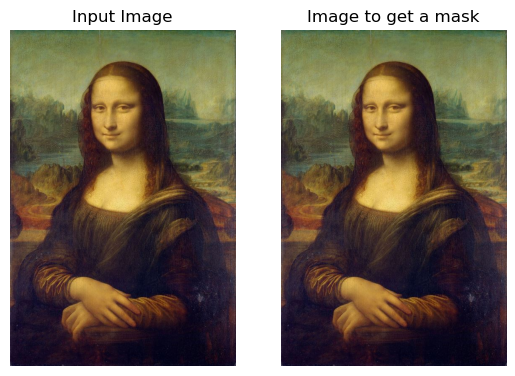

In [15]:
input_image_path = "monalisa.jpeg" 
mask_image_path = "monalisa.jpeg" 

input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
mask_image = cv2.imread(input_image_path)
mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Input Image')
plt.axis('off')  # Turn off axis labels

plt.subplot(1, 2, 2)
plt.imshow(mask_image)
plt.title('Image to get a mask')
plt.axis('off')  # Turn off axis labels
plt.show()


In [35]:
def getMask(mask_image):
    # Get the ROI using cv2.selectROI
    rect_roi = cv2.selectROI(input_image)
    cv2.destroyAllWindows()

    return input_image[int(rect_roi[1]):int(rect_roi[1]+rect_roi[3]),
                int(rect_roi[0]):int(rect_roi[0]+rect_roi[2])] 

def getRegionToMask(input_image):
    rect_roi = cv2.selectROI(input_image)
    cv2.destroyAllWindows()

    return rect_roi

def setMaskImage(input_image, region_to_mask, mask):   

    # Create a white image
    white_image = np.ones_like(input_image) * 255

    # Calculate the center of the region_to_mask
    center_x = int(region_to_mask[0] + region_to_mask[2] / 2)
    center_y = int(region_to_mask[1] + region_to_mask[3] / 2)

    # Calculate the position to place the mask in the new image
    start_x = center_x - int(mask.shape[1] / 2)
    start_y = center_y - int(mask.shape[0] / 2)

    # Create a new image with the mask placed in the specified region
    result_image = white_image.copy()
    result_image[start_y:start_y + mask.shape[0], start_x:start_x + mask.shape[1]] = mask

    return result_image

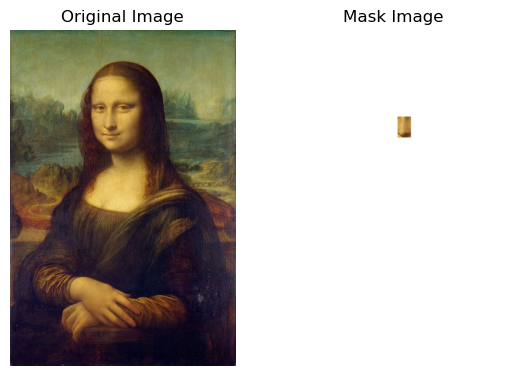

In [42]:
# Get the mask from the mask image (second image)
mask = getMask(mask_image)

# Get the region to mask from input image (first image)
region_to_mask = getRegionToMask(input_image)

image1 = input_image
image2 = setMaskImage(input_image, region_to_mask, mask)


plt.subplot(1, 2, 1)
plt.imshow(image1, cmap='gray')
plt.title("Original Image")
plt.axis('off')


plt.subplot(1, 2, 2)
plt.imshow(image2, cmap='gray')
plt.title("Mask Image")
plt.axis('off')

plt.show()

In [43]:
image1.shape

(800, 537, 3)

In [44]:
image2.shape

(800, 537, 3)

In [30]:
def build_laplacian_pyramid(image):
    pyramid = [image]
    for _ in range(6):  # Adjust the number of levels as needed
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid

def build_gaussian_pyramid(mask):
    pyramid = [mask]
    for _ in range(6):  # Adjust the number of levels as needed
        mask = cv2.pyrDown(mask)
        pyramid.append(mask)
    return pyramid

def blend_images(laplacian_pyr1, laplacian_pyr2, mask_pyr):
    blended_pyr = []
    for l1, l2, mask in zip(laplacian_pyr1, laplacian_pyr2, mask_pyr):
        blended_level = l1 * mask + l2 * (1 - mask)
        blended_pyr.append(blended_level)
    return blended_pyr

def collapse_pyramid(pyramid):
    collapsed_image = pyramid[-1]
    for level in reversed(pyramid[:-1]):
        collapsed_image = cv2.pyrUp(collapsed_image)
        collapsed_image += level
    return collapsed_image

In [ ]:
def generate_gaussian_pyramid(image, num_levels):
    pyramid = [image]
    for _ in range(num_levels - 1):
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid

def generate_laplacian_pyramid(gaussian_pyramid):
    pyramid = [gaussian_pyramid[-1]]
    for i in range(len(gaussian_pyramid) - 2, -1, -1):
        expanded = cv2.pyrUp(gaussian_pyramid[i + 1])
        if expanded.shape[:2] != gaussian_pyramid[i].shape[:2]:
            expanded = cv2.resize(expanded, (gaussian_pyramid[i].shape[1], gaussian_pyramid[i].shape[0]))
        laplacian = cv2.subtract(gaussian_pyramid[i], expanded)
        pyramid.insert(0, laplacian)
    return pyramid

def generate_masked_gaussian_pyramid(gaussian_pyramid, region_mask):
    masked_pyramid = [gaussian_pyramid[i] * region_mask for i in range(len(gaussian_pyramid))]
    return masked_pyramid

def blend_pyramids(laplacian_pyramid1, laplacian_pyramid2, masked_gaussian_pyramid):
    blended_pyramid = []
    for i in range(len(laplacian_pyramid1)):
        blended_level = laplacian_pyramid1[i] * masked_gaussian_pyramid[i] + \
                        laplacian_pyramid2[i] * (1 - masked_gaussian_pyramid[i])
        blended_pyramid.append(blended_level)
    return blended_pyramid

def reconstruct_image(pyramid):
    reconstructed = pyramid[0]
    for i in range(1, len(pyramid)):
        reconstructed = cv2.add(cv2.pyrUp(reconstructed), pyramid[i])
    return reconstructed

In [ ]:
# Generate Gaussian pyramids
gaussian_pyramid1 = generate_gaussian_pyramid(input_image, num_levels=5)
gaussian_pyramid2 = generate_gaussian_pyramid(mask_image, num_levels=5)

# Generate Laplacian pyramids
laplacian_pyramid1 = generate_laplacian_pyramid(gaussian_pyramid1)
laplacian_pyramid2 = generate_laplacian_pyramid(gaussian_pyramid2)

mask

masked_gaussian_pyramid = generate_masked_gaussian_pyramid(gaussian_pyramid1, mask)
blended_pyramid = blend_pyramids(laplacian_pyramid1, laplacian_pyramid2, masked_gaussian_pyramid)

# Reconstruct the final blended image
result_image = reconstruct_image(blended_pyramid)

# Display the result
cv2.imshow("Blended Image", result_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

ValueError: operands could not be broadcast together with shapes (400,269,3) (800,537,3) 